## 画像の読み込み

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# WIDTH = 480
# HEIGHT = 270
WIDTH = 160
HEIGHT = 90

def load_image(filename):
    image = Image.open(filename)
    image = image.resize((WIDTH, HEIGHT))
    return np.array(image)

# 過去にロード済みの場合は、npyファイルから読み込む　(高速化)
# 初めてロードする場合は、WIDTH, HEIGHTにリサイズする
def load_image_arr(name):
    filename = '{}_images_{}x{}.npy'.format(name, WIDTH, HEIGHT)
    if os.path.exists(filename):
        images = np.load(filename)
        return images

    filenames = glob.glob('car_images/{}/*'.format(name))
    images = np.zeros([len(filenames), HEIGHT, WIDTH, 3])

    # 画像の解像度を1920x1080に統一する
    total_count = len(filenames)
    with tqdm(total=total_count) as pbar:
        for i, filename in enumerate(filenames):
            pbar.update(1)
            images[i] = load_image(filename)

    np.save('{}_images_{}x{}'.format(name, WIDTH, HEIGHT), images)
    return images

In [3]:
import os
import glob
from tqdm import tqdm

# 「未来的/懐かしい」画像をロードする
new_images = load_image_arr('new')
old_images = load_image_arr('old')
print(new_images.shape)
print(old_images.shape)

(66, 90, 160, 3)
(44, 90, 160, 3)


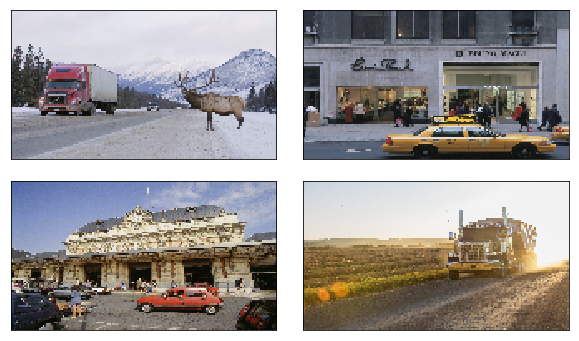

In [7]:
# 未来的
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw=dict(hspace=0.1, wspace=0.1), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(Image.fromarray(np.uint8(new_images[i])));

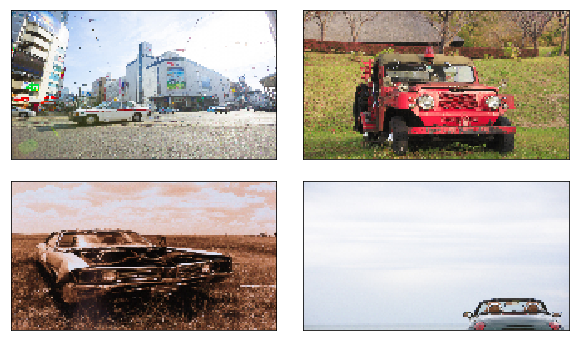

In [8]:
# 懐かしい
fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw=dict(hspace=0.1, wspace=0.1), subplot_kw=dict(xticks=[], yticks=[]))
for i, ax in enumerate(axes.flat):
    ax.imshow(Image.fromarray(np.uint8(old_images[i])));

## モデルの作成

In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Lambda, Input, Dense, Flatten
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD

nb_classes = 2
input_shape = (HEIGHT, WIDTH, 3)

# VGG3層 + 全結合層のネットワークを構成
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block1_pool'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block2_pool'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='block3_pool'))
model.add(Flatten(name='flatten'))
# model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc1'))
model.add(Dropout(0.5, name='dropout1'))
# model.add(Dense(4096, activation='relu', name='fc1'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dropout(0.5, name='dropout2'))
model.add(Dense(nb_classes))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

Using TensorFlow backend.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 90, 160, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 160, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 80, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               58982656  
_________________________________________________________________
dropout1 (Dropout)           (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 256)               65792     
__________

## データの整形と学習

In [6]:
# 「未来的/懐かしい」ラベルを作成
new_labels = np.array([0 for _ in range(len(new_images))])
old_labels = np.array([1 for _ in range(len(old_images))])

In [7]:
import os
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

X = np.concatenate([new_images, old_images])
X /= 255 # 正規化
Y = np.concatenate([new_labels, old_labels])

# 学習中のコールバック
model_weights = "./vgg_model.h5"
## 過学習の抑制
early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)
## テンソルボード
tensorboard = TensorBoard(log_dir=".tflog/", histogram_freq=1)
## 評価に用いるモデル重みデータの保存
checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stopping, tensorboard, checkpointer]

# 評価に用いるモデル構造の保存
def save_model(model):
    dirname = '.vgg_model'
    model_name = "arc.json"
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    with open(os.path.join(dirname, model_name),"w") as f:   
        f.write(model.to_json())

In [ ]:
epochs = 2
batch_size = 10
n_splits = 5

# 交差検証
kf = KFold(n_splits=n_splits, shuffle=True)

X_train, X_test = X[:10], X[10:20]
Y_train, Y_test = Y[:10], Y[10:20]
    
# data argumentation
datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, fill_mode='nearest')
datagen.fit(X_train)
datagen.fit(X_test)
    
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
    
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # data argumentation
    datagen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, fill_mode='nearest')
    datagen.fit(X_train)
    datagen.fit(X_test)
    
    Y_train = np_utils.to_categorical(Y_train, nb_classes)
    Y_test = np_utils.to_categorical(Y_test, nb_classes)
    
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                                  samples_per_epoch=X_train.shape[0],
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X_test, Y_test),
                                  callbacks=callbacks)
    
save_model(model)

/Users/k.takeuchi/Documents/whitepaper/amana-car/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=2, verbose=1, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=8)`


Epoch 1/2
8/8 [==============================] - 17s 2s/step - loss: 0.7258 - acc: 0.5125 - val_loss: 0.5810 - val_acc: 0.7273

Epoch 00001: val_loss improved from inf to 0.58102, saving model to ./vgg_model.h5
Epoch 2/2
8/8 [==============================] - 18s 2s/step - loss: 0.7869 - acc: 0.5000 - val_loss: 0.6155 - val_acc: 0.7273

Epoch 00002: val_loss did not improve from 0.58102
Epoch 1/2
8/8 [==============================] - 17s 2s/step - loss: 0.7412 - acc: 0.5375 - val_loss: 0.7205 - val_acc: 0.4545

Epoch 00001: val_loss did not improve from 0.58102
Epoch 2/2
8/8 [==============================] - 19s 2s/step - loss: 0.6991 - acc: 0.5585 - val_loss: 0.7177 - val_acc: 0.4545

Epoch 00002: val_loss did not improve from 0.58102
Epoch 1/2
8/8 [==============================] - 16s 2s/step - loss: 0.6673 - acc: 0.6000 - val_loss: 0.6656 - val_acc: 0.6364

Epoch 00001: val_loss did not improve from 0.58102
Epoch 2/2
6/8 [=====================>........] - ETA: 3s - loss: 0.6766 -

## GradCAMでのヒートマップの表示

In [14]:
import keras.backend as K
import cv2


def grad_cam(input_model, x, layer_name):
    '''
    Args:
       input_model: モデルオブジェクト
       x: 画像(array)
       layer_name: 畳み込み層の名前

    Returns:
       jetcam: 影響の大きい箇所を色付けした画像(array)

    '''

    # 前処理
    X = np.expand_dims(x, axis=0)

    X = X.astype('float32')
    preprocessed_input = X / 255.0


    # 予測クラスの算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    try:
        model.get_output_at(0)
    except Exception:
        pass
    class_output = model.output[:, class_idx]


    #  勾配を取得
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
        try:
        model.get_input_at(0)
    except Exception:
        pass
    gradient_function = K.function([model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)


    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0) 
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x / 2)   # もとの画像に合成

    return jetcam


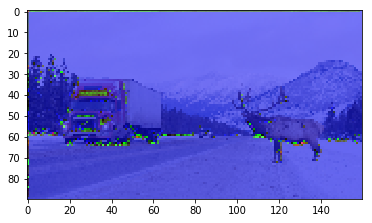

In [19]:
# 未来的な画像とヒートマップを表示
input_image = new_images[0]
cam = grad_cam(model, input_image, 'block1_conv1')
plt.imshow(Image.fromarray(np.uint8(cam)));

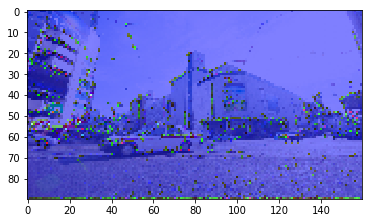

In [20]:
# 懐かしい画像とヒートマップを表示
input_image = old_images[0]
cam = grad_cam(model, input_image, 'block1_conv1')
plt.imshow(Image.fromarray(np.uint8(cam)));